#### Presence absence analysis of the DK0911 genome based on orthology



#### Usefull folders

- Warrior TE analysis: /home/benjamin/genome_assembly/Warrior/TE_analysis
- Pst_104_TE analysis: /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/REPET/TE_analysis
- comparative coverage: /home/benjamin/genome_assembly/Warrior/TE_analysis


In [1]:
%matplotlib inline

In [2]:
import os
from pybedtools import BedTool
import pandas as pd
import scipy
import pandas as pd
import numpy as np # need for  stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from scipy.stats import spearmanr
from scipy.stats import wilcoxon
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from seaborn import boxenplot
import pybedtools

In [121]:
DK0911_ortho_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/DK0911_vs_Ps104E_v13/'
Pst_104E_ortho_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/Ps104E_v13_vs_DK0911/'
DK0911_genome_file_fn = '/home/benjamin/genome_assembly/Warrior/genome_v04/DK_0911_v04_ph_ctg.genome_file'
Pst_104E_genome_file_fn = \
'/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_ph_ctg.genome_file'
WGA_PAA_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/mummer4'
LOWCOV_PAA_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/SRM_mapping/filtered/'
ORTHOFINDER_FILE_NAME = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/result_update_redundant_protein_sets_01032019/Orthogroups_3_combined.csv'
OUT_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/downstream_analysis/'

* do simple checks if any of the genes is more likely to lack orthologs then others e.g. BUSCOS vs effectors and such
* check if the missing orthologs overlap with other missing genes
* pull in the Synet file for synteny and ask if effectors are in longer blogs or ask what is the speciatly of shorter blogs or now hits


In [4]:
!ls {Pst_104E_ortho_dir}

190312_Ps104E_v13_vs_DK0911_allele.csv
190312_Ps104E_v13_vs_DK0911_down_match_simple_true_df.csv
190312_Ps104E_v13_vs_DK0911_paraloge.csv
190312_Ps104E_v13_vs_DK0911_singleton.csv
190312_Ps104E_v13_vs_DK0911_up_match_simple_true_df.csv


In [5]:
!head {DK0911_ortho_dir}/190506_DK0911_vs_Ps104E_v13_allele.csv

,Query,Target
0,DK0911_04470,Pst104E_20672
1,DK0911_19442,Pst104E_25968
2,DK0911_14147,Pst104E_08558
3,DK0911_22378,Pst104E_12318
4,DK0911_27396,Pst104E_11533
5,DK0911_19630,Pst104E_18568
6,DK0911_04166,Pst104E_06388
7,DK0911_07394,Pst104E_03870
8,DK0911_14215,Pst104E_24248


In [6]:
!head {DK0911_ortho_dir}/190506_DK0911_vs_Ps104E_v13_singleton.csv

,Query,Target
0,DK0911_27939,True
1,DK0911_29816,True
2,DK0911_24709,True
3,DK0911_10401,True
4,DK0911_02134,True
5,DK0911_12283,True
6,DK0911_29162,True
7,DK0911_10479,True
8,DK0911_12717,True


In [7]:
###all the bedfiles
Pst_104E_annotation_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/Pst104E_annotations/'
Pst_104E_dict = {}
Pst_104E_dict['Busco'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.busco.gene.bed')
Pst_104E_dict['All_genes'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.genes.gene.bed')
Pst_104E_dict['Secretome'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.secretome.gene.bed')
Pst_104E_dict['Ceffectors'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.ceffectors.gene.bed')
Pst_104E_dict['EffectorP'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.effectorp.gene.bed')
Pst_104E_dict['TE_superfamily'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.104Ep_DK0911p.REPET.superfamily.gff')
Pst_104E_dict['Lowcov_01'] = os.path.join(LOWCOV_PAA_dir, 'Pst_104E_v13_ph_ctg.bwamem.DK0911_gDNA.ph_window_w1000s200.ph_mapping.lowcov01.filtered.bed')
Pst_104E_dict['WGA_95'] = os.path.join(WGA_PAA_dir, 'Pst_104E_v13_ph_ctg.DK_0911_v04_ph_ctg.l100.c500.mm.deltafilter_i95mu0g_.nr_reverse.bed')
Pst_104E_dict['Singletons'] = os.path.join(Pst_104E_ortho_dir,'190312_Ps104E_v13_vs_DK0911_singleton.csv')
Pst_104E_dict['Alleles'] = os.path.join(Pst_104E_ortho_dir, '190312_Ps104E_v13_vs_DK0911_allele.csv')
Pst_104E_dict['Paraloges'] = os.path.join(Pst_104E_ortho_dir, '190312_Ps104E_v13_vs_DK0911_paraloge.csv')

In [8]:
###all the bedfiles
DK0911_annotation_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/DK0911_annotations/'
DK0911_dict = {}
DK0911_dict['Busco'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.busco.gene.bed')
DK0911_dict['All_genes'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.genes.gene.bed')
DK0911_dict['Secretome'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.secretome.gene.bed')
DK0911_dict['Ceffectors'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.effectorp20.gene.bed')
DK0911_dict['EffectorP'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.effectorp20.gene.bed')
DK0911_dict['TE_superfamily'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.104Ep_DK0911p.REPET.superfamily.gff')
DK0911_dict['Lowcov_01'] = os.path.join(LOWCOV_PAA_dir, 'DK_0911_v04_ph_ctg.bwamem.Pst79_TS.RG.mark_dup.ph_window_w1000s200.ph_mapping.lowcov01.filtered.bed' )
DK0911_dict['WGA_95'] = os.path.join(WGA_PAA_dir, 'DK_0911_v04_ph_ctg.Pst_104E_v13_ph_ctg.l100.c500.mm.deltafilter_i95mu0g_.nr_reverse.bed')
DK0911_dict['Singletons'] = os.path.join(DK0911_ortho_dir,'190506_DK0911_vs_Ps104E_v13_singleton.csv')
DK0911_dict['Alleles'] = os.path.join(DK0911_ortho_dir, '190506_DK0911_vs_Ps104E_v13_allele.csv')
DK0911_dict['Paraloges'] = os.path.join(DK0911_ortho_dir, '190506_DK0911_vs_Ps104E_v13_paraloge.csv')

In [9]:
def overlap_feature_names(bed_a_fn, bed_b_fn, min_f_overlap):
    """Count the number of unqiue genes that intersect witht basence bedfile.
    Assumes bed_a_fn is a bed six file."""
    bed_a = BedTool(bed_a_fn)
    bed_b = BedTool(bed_b_fn)
    return bed_a.intersect(bed_b, f=min_f_overlap).to_dataframe().name.unique()

In [10]:
def get_sing_para(fn):
    if 'singleton' in fn:
        return pd.read_csv(fn)['Query'].tolist()
    elif 'paraloge' in fn:
        queries = pd.read_csv(fn)['Query'].tolist()
        targets = pd.read_csv(fn)['Target'].tolist()
        return queries, targets
    else:
        raise ValueError

In [93]:
def get_gene_list(bed_fn):
    df = pd.read_csv(bed_fn, header=None, sep='\t')
    return df[3].unique()

In [11]:
def subset_bed(name_list, bed_fn, out_fn):
    df = pd.read_csv(bed_fn, header=None, sep='\t')
    df[df[3].isin(name_list)].to_csv(out_fn, sep='\t', header=None, index=None)
    return out_fn

In [12]:
def random_genes(bed_fn, n):
    df = pd.read_csv(bed_fn, header=None, sep='\t')
    return df.sample(n)[3].tolist()

In [13]:
def fisher_p(test_list, expect_list):
    return fisher_exact([[len(test_list[0]), len(test_list[1])], [len(expect_list[0]), len(expect_list[1])]])[1]

In [14]:
def count_genes_in_bed(bed_fn):
    return pd.read_csv(bed_fn, header=None, sep='\t').shape[0]

In [15]:
def summary_dict_to_df(summary_dict, outer_index, inner_index):
    """Convert as summary dict with multiple keys and values of same length. To a multiindex dataframe."""
    assert(outer_index[0:int(len(outer_index)/2)] == outer_index[int(len(outer_index)/2):])
    assert(inner_index[0:int(len(inner_index)/2)] == inner_index[int(len(inner_index)/2):])
    df = pd.DataFrame.from_dict(summary_dict)
    df['Cut_off'] = [x for x in outer_index[0:int(len(outer_index)/2)]]
    
    df['Type'] = inner_index[0:int(len(inner_index)/2)]
    df.sort_values(['Cut_off', 'Type'], inplace = True)
    index = pd.MultiIndex.from_tuples(list(zip(df['Cut_off'] , df['Type'])), names=['Cut-off', 'Type'])
    df.index = index
    return df.loc[:, df.columns[:2]].copy()

In [232]:
def plot_synteny(genome, df, color, out_fn):
   
    columns = [x for x in df.columns if genome in x][1:]
    
    f1, ax = plt.subplots(1, len(columns), figsize=(10, 5), sharey=True)
     

    for n, column in enumerate(columns):
        sns.violinplot(y=df[df[column] == True]['aln_length'], color=color, ax=ax[n], cut =0)
        #ax[y[0], y[1]].axhline(y=overlap, color='r', linestyle='-')
        #ax[n].set_title(column, fontsize=16)
        #ax[y[0], y[1]].set_yticklabels([])
        ax[n].set_ylabel('')
        ax[n].set_xlabel(column.replace(genome+"_",''), fontsize=16)
        ax[n].text(0.05, 370, 'n=%s' % df[df[column] == True].shape[0])
        if genome == 'DK0911':
            _dict = DK0911_dict
        elif genome =='Pst_104E':
            _dict = Pst_104E_dict
        ax[n].text(0.05, 350, 'max=%s' % len(get_gene_list\
                                               (_dict[column.replace(genome+"_",'')])))
    ax[0].set_ylabel('Synteny Block Size', fontsize=16)
    #f1.suptitle(genome)
    plt.tight_layout()
    #f1.suptitle(os.path.basename(out_fn))
    #plt.savefig(out_fn, dpi =300)
    sns.despine(f1)
    return f1

#### Start with a chek if all two inputs of orhtology and ben beds line up

In [138]:
DK_all = get_gene_list(DK0911_dict['All_genes'])
Pst_104_all = get_gene_list(Pst_104E_dict['All_genes'])

In [137]:
set(DK_all) == (set(pd.read_csv(DK0911_dict['Alleles'], header=None)[1][1:].unique())\
| set(get_sing_para(DK0911_dict['Paraloges'])[0]) | set(get_sing_para(DK0911_dict['Singletons']))) 

True

In [140]:
set(Pst_104_all) == (set(pd.read_csv(Pst_104E_dict['Alleles'], header=None)[1][1:].unique())\
| set(get_sing_para(Pst_104E_dict['Paraloges'])[0]) | set(get_sing_para(Pst_104E_dict['Singletons']))) 

True

In [23]:
#get the combined missing genes and test if the overlap is significant with a fishers exact test and randomization
min_overlap = 1
key = "WGA_LOWCOV_combined_mo%s" % str(min_overlap).replace('.','')

for _dict in [DK0911_dict, Pst_104E_dict]:
    WGA_genes = overlap_feature_names(_dict['All_genes'], _dict['WGA_95'], min_overlap)
    WGA_random = random_genes(_dict['All_genes'], len(WGA_genes))
    LOWCOV_genes = overlap_feature_names(_dict['All_genes'], _dict['Lowcov_01'], min_overlap)
    LOWCOV_random = random_genes(_dict['All_genes'], len(LOWCOV_genes))
    genome = os.path.basename(_dict['All_genes']).split('.')[0]
    overlap_list = [x for x in WGA_genes if x in LOWCOV_genes]
    random_overlap_list = [x for x in WGA_random if x in LOWCOV_random]
    out_fn = os.path.join(OUT_dir, '%s.%s.bed' % (genome, key))
    _dict[key] = subset_bed(overlap_list, _dict['All_genes'], out_fn)
    p_WGA = fisher_p([overlap_list, WGA_genes],[random_overlap_list, WGA_genes] )
    p_LOWCOV = fisher_p([overlap_list, LOWCOV_genes],[random_overlap_list, LOWCOV_genes] )
    print('For %s:\nWGA_missing:%s, %.2E\nLOWCOV_missing:%s, %.2E\nCombined_missing:%s\nRandom_missing:%s\n'%\
         (genome, len(WGA_genes), p_WGA,  len(LOWCOV_genes), p_LOWCOV, len(overlap_list), len(random_overlap_list)))

For DK_0911_v04_ph_ctg:
WGA_missing:553, 1.48E-31
LOWCOV_missing:724, 1.46E-32
Combined_missing:185
Random_missing:18

For Pst_104E_v13_ph_ctg:
WGA_missing:2084, 5.74E-201
LOWCOV_missing:2394, 3.32E-207
Combined_missing:1441
Random_missing:151



In [37]:
for _dict in [DK0911_dict, Pst_104E_dict]:
    WGA_genes = overlap_feature_names(_dict['All_genes'], _dict['WGA_95'], min_overlap)
    WGA_random = random_genes(_dict['All_genes'], len(WGA_genes))
    singletons = get_sing_para(_dict['Singletons'])
    singletons_random = random_genes(_dict['All_genes'], len(singletons))
    genome = os.path.basename(_dict['All_genes']).split('.')[0]
    overlap_list = [x for x in WGA_genes if x in singletons]
    random_overlap_list = [x for x in WGA_random if x in singletons_random]
    
    p_WGA = fisher_p([overlap_list, WGA_genes],[random_overlap_list, WGA_genes] )
    p_sing = fisher_p([overlap_list, singletons],[random_overlap_list, singletons] )
    print('For %s:\nWGA_missing:%s, %.2E\nSingletons_missing:%s, %.2E\nCombined_missing:%s\nRandom_missing:%s\n'%\
         (genome, len(WGA_genes), p_WGA,  len(singletons), p_sing, len(overlap_list), len(random_overlap_list)))



For DK_0911_v04_ph_ctg:
WGA_missing:553, 1.94E-15
Singletons_missing:1275, 2.36E-16
Combined_missing:133
Random_missing:29

For Pst_104E_v13_ph_ctg:
WGA_missing:2084, 1.08E-27
Singletons_missing:1404, 1.28E-26
Combined_missing:345
Random_missing:107



In [39]:
for _dict in [DK0911_dict, Pst_104E_dict]:
    WGA_genes = overlap_feature_names(_dict['All_genes'], _dict['WGA_95'], min_overlap)
    WGA_random = random_genes(_dict['All_genes'], len(WGA_genes))
    singletons = get_sing_para(_dict['Singletons'])
    singletons_random = random_genes(_dict['All_genes'], len(singletons))
    genome = os.path.basename(_dict['All_genes']).split('.')[0]
    LOWCOV_genes = overlap_feature_names(_dict['All_genes'], _dict['Lowcov_01'], min_overlap)
    LOWCOV_random = random_genes(_dict['All_genes'], len(LOWCOV_genes))
    
    overlap_list = [x for x in WGA_genes if x in singletons and x in LOWCOV_genes]
    random_overlap_list = [x for x in WGA_random if x in singletons_random and LOWCOV_random]
    
    p_WGA = fisher_p([overlap_list, WGA_genes],[random_overlap_list, WGA_genes] )
    p_sing = fisher_p([overlap_list, singletons],[random_overlap_list, singletons] )
    p_LOWCOV = fisher_p([overlap_list, LOWCOV_genes],[random_overlap_list, LOWCOV_genes] )
    print('For %s:\nWGA_missing:%s, %.2E\nSingletons_missing:%s, %.2E\nLOWCOV_missing:%s, %.E2\nCombined_missing:%s\nRandom_missing:%s\n'%\
         (genome, len(WGA_genes), p_WGA,  len(singletons), p_sing, len(LOWCOV_genes), p_LOWCOV,  len(overlap_list), len(random_overlap_list)))

For DK_0911_v04_ph_ctg:
WGA_missing:553, 2.86E-03
Singletons_missing:1275, 2.37E-03
LOWCOV_missing:724, 3E-032
Combined_missing:55
Random_missing:27

For Pst_104E_v13_ph_ctg:
WGA_missing:2084, 1.58E-24
Singletons_missing:1404, 8.68E-24
LOWCOV_missing:2394, 8E-252
Combined_missing:276
Random_missing:80



In [31]:
#numbers of overlaps in missing` vs. gene category and the states (as before)
Fishers_summary_dict = {}
Absence_summary_dict = {}
outer_index = [] #being the cut off
inner_index = [] #being the type of gene to look at
Fishers_summary_dict['DK0911'] = []
Fishers_summary_dict['Pst_104E'] = []
Absence_summary_dict['DK0911'] = []
Absence_summary_dict['Pst_104E'] = []
min_overlap = 1
key = ''
gene_keys = ['All_genes','Busco', 'Ceffectors',  'EffectorP',   'Secretome']
missing_keys = ['Lowcov_01', 'WGA_95',  'WGA_LOWCOV_combined_mo1',]

for _dict in [DK0911_dict, Pst_104E_dict]:
    for gene_key in gene_keys:
        for missing_key in missing_keys:
        
            inner_index.append(missing_key)
            outer_index.append(gene_key)
            category_genes_missing = overlap_feature_names(_dict[gene_key], _dict[missing_key], min_overlap)
            all_genes_missing = overlap_feature_names(_dict['All_genes'], _dict[missing_key], min_overlap)
            p_value = fisher_exact([[len(category_genes_missing), count_genes_in_bed(_dict[gene_key])],\
                              [len(all_genes_missing), count_genes_in_bed(_dict['All_genes'])]])[1]
            percent_lost = round(len(category_genes_missing)/count_genes_in_bed(_dict[gene_key])*100, 2)
            absence_value = [len(category_genes_missing), count_genes_in_bed(_dict[gene_key]), percent_lost]
            if os.path.basename(_dict['All_genes']).startswith('DK'):
                key = 'DK0911'
            elif os.path.basename(_dict['All_genes']).startswith('Pst_104'):
                key = 'Pst_104E'
            
            Fishers_summary_dict[key].append(p_value)
            Absence_summary_dict[key].append(absence_value)

In [32]:
Fishers_df = summary_dict_to_df(Fishers_summary_dict, outer_index, inner_index)
Absence_df = summary_dict_to_df(Absence_summary_dict, outer_index, inner_index)

In [33]:
Fishers_df

DK0911      Pst_104E
Cut-off    Type                                               
All_genes  Lowcov_01                1.000000e+00  1.000000e+00
           WGA_95                   1.000000e+00  1.000000e+00
           WGA_LOWCOV_combined_mo1  1.000000e+00  1.000000e+00
Busco      Lowcov_01                2.108868e-12  5.455648e-10
           WGA_95                   4.579768e-05  1.324495e-13
           WGA_LOWCOV_combined_mo1  1.477667e-03  9.379411e-17
Ceffectors Lowcov_01                3.326542e-02  5.836811e-02
           WGA_95                   9.235022e-01  3.479875e-03
           WGA_LOWCOV_combined_mo1  7.400221e-01  5.795804e-03
EffectorP  Lowcov_01                3.326542e-02  4.923270e-02
           WGA_95                   9.235022e-01  5.003802e-01
           WGA_LOWCOV_combined_mo1  7.400221e-01  7.886652e-01
Secretome  Lowcov_01                1.436367e-06  5.983996e-02
           WGA_95                   1.839260e-02  2.438171e-03
           WGA_LOWCOV_combined_mo1  1.750980e-02  6.937300e-05

In [34]:
Absence_df 

DK0911             Pst_104E
Cut-off    Type                                                            
All_genes  Lowcov_01                [724, 25940, 2.79]  [2394, 30249, 7.91]
           WGA_95                   [553, 25940, 2.13]  [2084, 30249, 6.89]
           WGA_LOWCOV_combined_mo1  [185, 25940, 0.71]  [1441, 30249, 4.76]
Busco      Lowcov_01                   [13, 2178, 0.6]     [126, 2740, 4.6]
           WGA_95                     [20, 2178, 0.92]     [91, 2740, 3.32]
           WGA_LOWCOV_combined_mo1     [4, 2178, 0.18]     [44, 2740, 1.61]
Ceffectors Lowcov_01                  [25, 1376, 1.82]    [244, 3520, 6.93]
           WGA_95                     [28, 1376, 2.03]    [194, 3520, 5.51]
           WGA_LOWCOV_combined_mo1     [8, 1376, 0.58]    [130, 3520, 3.69]
EffectorP  Lowcov_01                  [25, 1376, 1.82]    [189, 2038, 9.27]
           WGA_95                     [28, 1376, 2.03]    [149, 2038, 7.31]
           WGA_LOWCOV_combined_mo1     [8, 1376, 0.58]    [100, 2038, 4.91]
Secretome  Lowcov_01                  [55, 3699, 1.49]    [327, 4637, 7.05]
           WGA_95                     [57, 3699, 1.54]    [261, 4637, 5.63]
           WGA_LOWCOV_combined_mo1    [14, 3699, 0.38]    [159, 4637, 3.43]

In [29]:
#comparing number of genes in category with overlap in singletons
#get the combined missing genes and test if the overlap is significant with a fishers exact test and randomization

min_overlap = 1
key = ''
gene_keys = ['All_genes','Busco', 'Ceffectors',  'EffectorP',   'Secretome']
for _dict in [DK0911_dict, Pst_104E_dict]:
    for gene_key in gene_keys:    
        category_genes = overlap_feature_names(_dict['All_genes'], _dict[gene_key], min_overlap)
        all_genes = overlap_feature_names(_dict['All_genes'], _dict['All_genes'], min_overlap)
        singletons = get_sing_para(_dict['Singletons'])
            
        all_genes_overlap = [x for x in all_genes if x in singletons]
        
            
        catetory_genes_overlap = [x for x in category_genes if x in singletons]
               
        p_value = fisher_p([ catetory_genes_overlap, category_genes],[all_genes_overlap, all_genes])
        absence_value = [len(catetory_genes_overlap), len(category_genes), len(singletons)]
        percent_lost = len(catetory_genes_overlap)/len(category_genes) *100
        if os.path.basename(_dict['All_genes']).startswith('DK'):
            genome = 'DK0911'
        elif os.path.basename(_dict['All_genes']).startswith('Pst_104'):
            genome = 'Pst_104E'
        
            
        print('For %s:\n%s:%s, %.2E, %.2f'%\
         (genome, gene_key, absence_value,  p_value, percent_lost)) 
            
 

For DK0911:
All_genes:[1275, 25940, 1275], 1.00E+00, 4.92
For DK0911:
Busco:[7, 2178, 1275], 5.91E-34, 0.32
For DK0911:
Ceffectors:[53, 1376, 1275], 9.31E-02, 3.85
For DK0911:
EffectorP:[53, 1376, 1275], 9.31E-02, 3.85
For DK0911:
Secretome:[109, 3699, 1275], 9.30E-08, 2.95
For Pst_104E:
All_genes:[1404, 30249, 1404], 1.00E+00, 4.64
For Pst_104E:
Busco:[17, 2740, 1404], 1.06E-31, 0.62
For Pst_104E:
Ceffectors:[153, 2960, 1404], 2.20E-01, 5.17
For Pst_104E:
EffectorP:[142, 2038, 1404], 2.07E-05, 6.97
For Pst_104E:
Secretome:[190, 4637, 1404], 1.21E-01, 4.10


In [40]:
syn_net_folder = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/run_SynNet/Genomes20190401_2103-SynNet-k0w0m25'
syn_net_file = os.path.join(syn_net_folder, 'DK_PAu.collinearity')

In [153]:
fn = syn_net_file

want to get for each gene the position in the alignement, the length of the alignment, the alignement name, plus its match.


In [160]:
synteny_dict = {}
synteny_dict['aln_name'] = []
synteny_dict['aln_position'] = []
synteny_dict['aln_length'] = []
synteny_dict['Pst_104E'] = []
synteny_dict['DK0911'] = []
synteny_dict['distance_5'] = []
synteny_dict['distance_3'] = []
len_pattern = re.compile(r'N=([^ ]*)')
d_pattern = re.compile(r'DK[^\t]*')
p_pattern = re.compile(r'Pst[^\t]*')
position_pattern = re.compile(r'-([^:]*)')
count = 0
with open(fn, 'r') as fh:
    for line in fh:
        line.rstrip()
        count = count + 1
        if line.startswith(r'## '):
            aln_len = int(re.findall(len_pattern, line)[0])
            aln_name = line.split(':')[0][3:]
        elif not line.startswith(r'#'):
            aln_position = int(re.findall(position_pattern , line)[0].replace(' ', ''))
            synteny_dict['DK0911'].append(re.findall(d_pattern, line)[0])
            synteny_dict['Pst_104E'].append(re.findall(p_pattern, line)[0])
            synteny_dict['aln_name'].append(aln_name)
            synteny_dict['aln_length'].append(aln_len)
            synteny_dict['aln_position'].append(aln_position)
            synteny_dict['distance_5'].append(aln_position)
            synteny_dict['distance_3'].append(aln_len - aln_position)
syn_df = pd.DataFrame.from_dict(synteny_dict)
syn_df

,DK0911,Pst_104E,aln_length,aln_name,aln_position,distance_3,distance_5
0,DK0911_00336,Pst104E_18142,6,Alignment 0,0,6,0
1,DK0911_00337,Pst104E_18143,6,Alignment 0,1,5,1
2,DK0911_00338,Pst104E_18144,6,Alignment 0,2,4,2
3,DK0911_00339,Pst104E_18145,6,Alignment 0,3,3,3
4,DK0911_00340,Pst104E_18146,6,Alignment 0,4,2,4
5,DK0911_00341,Pst104E_18147,6,Alignment 0,5,1,5
6,DK0911_00004,Pst104E_18230,230,Alignment 1,0,230,0
7,DK0911_00005,Pst104E_18231,230,Alignment 1,1,229,1
8,DK0911_00006,Pst104E_18232,230,Alignment 1,2,228,2
9,DK0911_00011,Pst104E_18233,230,Alignment 1,3,227,3


In [161]:
gene_keys = ['All_genes','Busco', 'Ceffectors',  'EffectorP',   'Secretome']
for gene_type in gene_keys:
    for _dict in [DK0911_dict, Pst_104E_dict]:
        if os.path.basename(_dict['All_genes']).startswith('DK'):
            key = 'DK0911_%s' % gene_type
            _tmp_index = syn_df['DK0911'].isin(get_gene_list(_dict[gene_type]))
            
        elif os.path.basename(_dict['All_genes']).startswith('Pst'):
            key = 'Pst_104E_%s' % gene_type

            
            _tmp_index = syn_df['Pst_104E'].isin(get_gene_list(_dict[gene_type]))
        print(key)
        print(np.mean(syn_df.loc[_tmp_index, 'aln_length']))
        print(np.median(syn_df.loc[_tmp_index, 'aln_length']))
        syn_df[key] = False
        syn_df.loc[_tmp_index, key] = True

DK0911_All_genes
59.551053898329805
23.0
Pst_104E_All_genes
59.551053898329805
23.0
DK0911_Busco
77.74589008924377
42.0
Pst_104E_Busco
78.15622182146078
42.5
DK0911_Ceffectors
66.33576158940397
30.0
Pst_104E_Ceffectors
64.18839501580807
29.0
DK0911_EffectorP
66.33576158940397
30.0
Pst_104E_EffectorP
64.71628972230175
30.0
DK0911_Secretome
63.06071757129715
28.0
Pst_104E_Secretome
62.88196983546618
27.0


In [162]:
syn_df.columns

Index(['DK0911', 'Pst_104E', 'aln_length', 'aln_name', 'aln_position',
       'distance_3', 'distance_5', 'DK0911_All_genes', 'Pst_104E_All_genes',
       'DK0911_Busco', 'Pst_104E_Busco', 'DK0911_Ceffectors',
       'Pst_104E_Ceffectors', 'DK0911_EffectorP', 'Pst_104E_EffectorP',
       'DK0911_Secretome', 'Pst_104E_Secretome'],
      dtype='object')

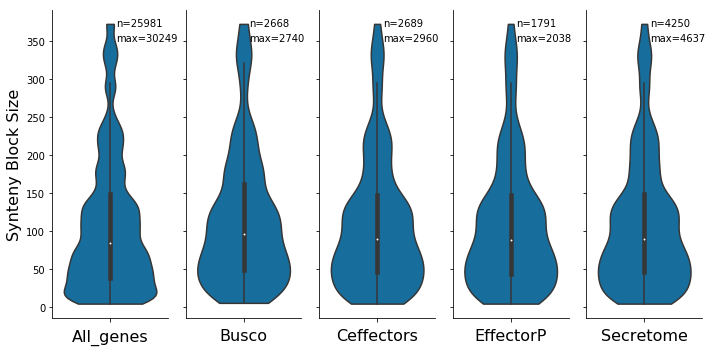

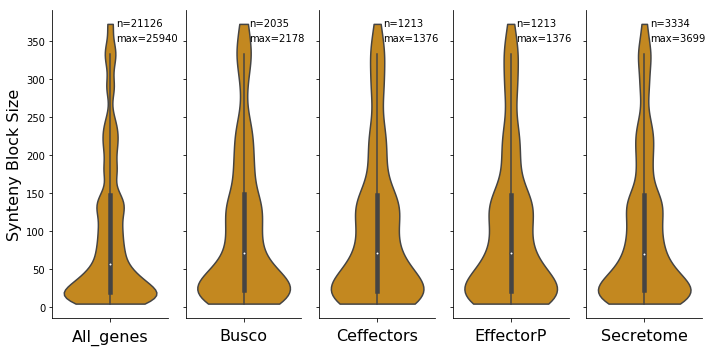

In [231]:
max_length_df_dict = {}
pallete = [sns.color_palette('colorblind')[x] for x in [0,1]]
for genome, color in zip(['Pst_104E', 'DK0911'], pallete): 
    idx = syn_df.groupby(genome)['aln_length'].transform(max) == syn_df['aln_length']
    max_length_df_dict[genome] = syn_df.loc[idx].drop_duplicates([genome, 'aln_length']).copy()
    for gene_type in syn_df.columns[-10:]:
        if genome in gene_type:
            _tmp_df = max_length_df_dict[genome]
      
            #print(genome, gene_type)
            #print(_tmp_df[_tmp_df[gene_type] == True]['aln_length'].mean())
    plot_synteny(genome, max_length_df_dict[genome], color, 'something')